In [1]:
import numpy as np
import openrouteservice
from openrouteservice.geocode import pelias_search
import xarray as xr
from datetime import datetime
from datetime import time as dtime
from datetime import date as ddate

ORS_API_KEY = "5b3ce3597851110001cf62485c01b629a61e4f57b5449ab3a0000ec5"

def get_temp_series(location = "Bergheimer Straße 116, 69115 Heidelberg, Germany"):
    """
    Given a location returns an xarray dataset of hourly temperatures in Kelvin
    INPUTS:
        something
    OUTPUTS:
        ds (xarray dataset): has coordinates [longitude (float32), latitude (float32), time (datetime64)]
        
    TODO: specify time bounds, properly comment
    """
    clnt = openrouteservice.Client(key=ORS_API_KEY)
    call = pelias_search(clnt, location)
    for feature in call["features"]:
        geom = feature["geometry"]["coordinates"]

    fn = "adaptor.mars.internal-1653931184.6044545-27675-10-90177a1a-903d-4c14-97ca-8193c514342a.nc"
    ds = xr.open_dataset(fn)
    #yearmonth = "2021-10-31"
    #yearmonth = datetime.strptime(yearmonth, '%Y-%m-%d')
    ds = ds.sel(latitude=round(geom[1])).sel(longitude=round(geom[0]))

    # interpolate missing hours of the day (sometimes data only from 06h to 22h)
    ds = ds.resample(time="1h").interpolate("linear")
    return ds


def mask_temp(data, Tref = 291.15):
    """
    INPUTS:
        data (xarray dataset): Must have datetimes in ["time"].values and temperatures in ["t2m"].values
        Tref (float): Reference temperature, given in Kelvin. Default is 291.15 (18 Celcius).
    OUTPUTS:
        something
    Note that for now I choose not to use heating start and stop times (ex. setting temp = Tref outside this range)
    becuase it adds complications, ex. the building will maintain some of the heating even if it is off... I think
    that turning the heating off will result in lower gas usage anyway... idk should talk about it
    """
    pass

    # hourly time series
    # compute degree days

In [3]:
ds = get_temp_series() 

In [4]:
#ddate(2021,2,1)
#dtime(12)
ds['time.month']

<xarray.DataArray 'month' (time: 17537)>
array([ 1,  1,  1, ..., 12, 12, 12])
Coordinates:
    longitude  float32 9.0
    latitude   float32 49.0
  * time       (time) datetime64[ns] 2020-01-01T06:00:00 ... 2021-12-31T22:00:00

In [ ]:
feb = ds.sel(time=slice('2020-02-01','2020-02-29'))

def calc_heating_dd(month_data,Tref = 291.15):
    

In [57]:
#ds.sel(time=slice('2020-02-01','2020-02-29'))
Tref = 291.15
#feb = ds.sel(time=slice('2020-02-01','2020-02-29'))
feb = ds.sel(time=slice('2020-02-01','2020-02-01'))
# for heating:
feb['t2m'] = Tref - feb['t2m']
# for cooling:
#feb['t2m'] = feb['t2m'] - Tref
# set everything below zero to 0:
feb = np.maximum(feb, 0)
# integrate
feb.integrate('time',datetime_unit='h')
#TODO: make sure this integrate works properly, then scale it properly for degree days

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    longitude  float32 9.0
    latitude   float32 49.0
Data variables:
    t2m        float64 162.0
Attributes:
    Conventions:  CF-1.6
    history:      2022-05-30 17:21:16 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

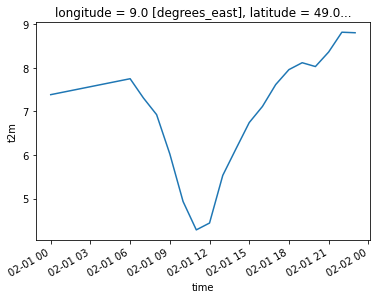

In [58]:

feb['t2m'].plot()



Temp: Assume we have a 2D numpy array with data, index 1 is date, index 2 is min and max temp

we will introduce 4 functions:
a) simple method based on average temperature
b) medium fidelity based on min and max temperature
c) high fidelity based on integration using hourly data (requires potential interpolation to hourly values)
d) high fidelity based on integration with option to only integrate from certain hours (ex. if heating is turned off at night)

use this to compare:
https://energy-data.io/services/degree-day-calculator-free/

In [26]:
feb = ds.sel(time=slice('2020-02-01','2020-02-29'))
feb2 = Tref - feb['t2m'] - 10
feb3 = np.maximum(feb2, 0)

In [48]:
diff_time = feb['time'][-1] -feb['time'][0]
np.timedelta64(diff_time,'D')

ValueError: Could not convert object to NumPy timedelta

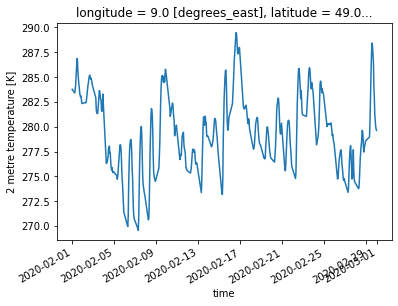

In [27]:
feb['t2m'].plot()

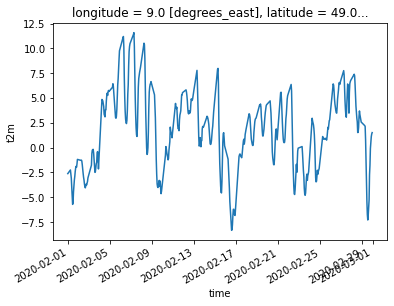

In [28]:
feb2.plot()

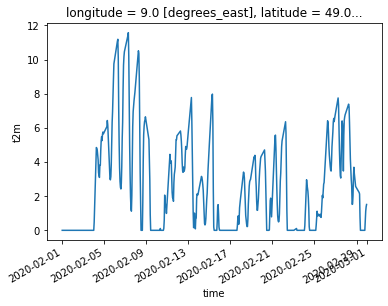

In [29]:
feb3.plot()
